Wed Jul 2nd 2025,
Jakob Balkovec

# Results

The purpose of this notebook is to ensure the pipeline is working correctly. The results from yesterday's (Jul 5th) report serve as a benchmark.

In [1]:
from pathlib import Path

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as mtpltlib_patches

import pandas as pd

from shapely.geometry.base import BaseGeometry
from shapely.affinity import scale, translate


## Configuration

In [49]:
PICKLE_PATH = Path.cwd().parent.parent / 'data' / 'patches' / 'frame' / 'patch_frame.pkl'

COLOR_MAP = {
    'hemorrhages': ('blue', 0.3),
    'microaneurysms': ('red', 0.3),
    'hard_exudates': ('green', 0.3),
    'soft_exudates': ('orange', 0.3),
    'irma': ('purple', 0.3),
    'neovascularization': ('cyan', 0.3),
}

TICK_COLOR_MAP = {
    'hemorrhages': 'white',
    'microaneurysms': 'yellow',
    'hard_exudates': 'black',
    'soft_exudates': 'blue',
    'irma': 'white',
    'neovascularization': 'black',
}


## Utility Functions

In [50]:
def plot_patch_with_lesions(df, n_cols=4, patch_size=25, resize_to=128):
    # pre: df contains patch info including 'patch_polygon' and 'lesion_shape'
    # post: displays patches with overlaid lesion shapes
    # desc: plots extracted patches with highlighted lesion polygons

    n = len(df)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 3.5), dpi=150)
    axs = axs.flatten()

    for i, (_, row) in enumerate(df.iterrows()):
        patch_img = row['patch']
        patch_no = row['patch_no']
        label = row['label']
        lesion_shapes = row['lesion_shape']
        patch_poly = row['patch_polygon']
        ax = axs[i]

        patch_img_resized = cv2.resize(patch_img, (resize_to, resize_to), interpolation=cv2.INTER_NEAREST)
        ax.imshow(patch_img_resized, cmap='gray' if patch_img.ndim == 2 else None)

        label_text = ", ".join(label) if isinstance(label, (list, tuple)) else label
        ax.set_title(f"#{patch_no} | {label_text}", fontsize=12)

        if isinstance(lesion_shapes, BaseGeometry):
            lesion_shapes = [lesion_shapes]
            label_list = [label] if isinstance(label, str) else label
        elif isinstance(lesion_shapes, list):
            label_list = label if isinstance(label, (list, tuple)) else [label]
        else:
            lesion_shapes, label_list = [], []

        x_offset, y_offset, _, _ = patch_poly.bounds

        for shape, lesion_type in zip(lesion_shapes, label_list):
            if not isinstance(shape, BaseGeometry):
                continue

            try:
                local_shape = translate(shape, xoff=-x_offset, yoff=-y_offset)
                scale_factor = resize_to / patch_size
                local_shape = scale(local_shape, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))

                color, alpha = COLOR_MAP.get(lesion_type, ('gray', 0.3))
                tick_color = TICK_COLOR_MAP.get(lesion_type, 'white')

                cx, cy = local_shape.centroid.xy
                ax.plot(cx[0], cy[0], marker='x', color=tick_color, markersize=3.5, linewidth=0.6)
                ax.text(cx[0] + 2, cy[0] - 2, lesion_type, fontsize=10, color=tick_color, weight='bold')

                poly_patch = mtpltlib_patches.Polygon(list(local_shape.exterior.coords),
                                                      linewidth=3.0, edgecolor=color,
                                                      facecolor=color, alpha=alpha)
                ax.add_patch(poly_patch)
            except Exception as e:
                print(f"Skipped shape for {lesion_type}: {e}")

        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_visible(True)

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


## Read in the `.pkl` File

In [51]:
patches_df = pd.read_pickle(PICKLE_PATH)
patches_df.head(n=10)


,patch,patch_no,x,y,lesion_type,patch_polygon,label,lesion_shape,overlap_flag,image_id,file_name
0,"[[105, 94, 81, 89, 91, 79, 86, 102, 86, 69, 71...",1,938,156,lesion,"POLYGON ((926 144, 950 144, 950 168, 926 168, ...",microaneurysms,"[POLYGON ((938.9980392156863 161, 939 160.9980...",False,0068_1,0068_1_microaneurysms_938_156.png
1,"[[82, 90, 101, 104, 107, 109, 117, 120, 109, 9...",2,530,350,lesion,"POLYGON ((518 338, 542 338, 542 362, 518 362, ...",microaneurysms,"[POLYGON ((533.9980392156863 357, 533.99803921...",False,0068_1,0068_1_microaneurysms_530_350.png
2,"[[63, 58, 41, 32, 61, 77, 82, 93, 82, 55, 43, ...",3,639,729,lesion,"POLYGON ((627 717, 651 717, 651 741, 627 741, ...",microaneurysms,"[POLYGON ((638.9980392156863 734, 639 733.9980...",False,0068_1,0068_1_microaneurysms_639_729.png
3,"[[73, 81, 89, 62, 62, 100, 110, 54, 57, 92, 70...",4,686,738,lesion,"POLYGON ((674 726, 698 726, 698 750, 674 750, ...",microaneurysms,"[POLYGON ((691.9980392156863 742, 691.99803921...",False,0068_1,0068_1_microaneurysms_686_738.png
4,"[[92, 94, 60, 73, 63, 94, 101, 61, 58, 90, 101...",5,480,841,lesion,"POLYGON ((468 829, 492 829, 492 853, 468 853, ...",hard_exudates,"[POLYGON ((468 853, 471.9980392156863 853, 471...",False,0068_1,0068_1_hard_exudates_480_841.png
5,"[[104, 95, 85, 112, 120, 130, 90, 101, 85, 90,...",6,522,864,lesion,"POLYGON ((510 852, 534 852, 534 876, 510 876, ...",microaneurysms,"[POLYGON ((522.9980392156863 870, 523 869.9980...",False,0068_1,0068_1_microaneurysms_522_864.png
6,"[[90, 85, 82, 71, 66, 79, 92, 90, 85, 95, 95, ...",7,399,875,lesion,"POLYGON ((387 863, 411 863, 411 887, 387 887, ...",microaneurysms,"[POLYGON ((399.9980392156863 880, 400 879.9980...",False,0068_1,0068_1_microaneurysms_399_875.png
7,"[[85, 101, 109, 79, 84, 63, 63, 60, 52, 31, 40...",8,342,936,lesion,"POLYGON ((330 924, 354 924, 354 948, 330 948, ...",microaneurysms,"[POLYGON ((344.9980392156863 939, 344.99803921...",False,0068_1,0068_1_microaneurysms_342_936.png
8,"[[76, 82, 79, 95, 79, 79, 90, 87, 111, 100, 10...",9,287,967,lesion,"POLYGON ((275 955, 299 955, 299 979, 275 979, ...",microaneurysms,"[POLYGON ((285.9980392156863 971, 286 970.9980...",False,0068_1,0068_1_microaneurysms_287_967.png
9,"[[105, 98, 87, 103, 71, 82, 95, 71, 92, 116, 1...",10,221,986,lesion,"POLYGON ((209 974, 233 974, 233 998, 209 998, ...",microaneurysms,"[POLYGON ((223.99803921568628 991, 224 990.998...",False,0068_1,0068_1_microaneurysms_221_986.png


## Sanity Checks

In [52]:
patches_df['label'].unique()


array(['microaneurysms', 'hard_exudates', 'hemorrhages', 'soft_exudates',
       'healthy'], dtype=object)

Good 👍🏻!

In [53]:
patches_df[patches_df["overlap_flag"]]


,patch,patch_no,x,y,lesion_type,patch_polygon,label,lesion_shape,overlap_flag,image_id,file_name


Good 👍🏻!

In [54]:
patches_df["label"].apply(lambda x: isinstance(x, tuple)).sum()


0

Good 👍🏻!

In [55]:
patches_df[patches_df["overlap_flag"]][["label", "x", "y"]].head()


,label,x,y


Good 👍🏻!

In [56]:
patches_df["patch"].apply(lambda x: x.shape).value_counts()


patch
(25, 25)    2736
Name: count, dtype: int64

Good 👍🏻!

In [57]:
len(patches_df[patches_df["label"] != "healthy"])


28

Good 👍🏻!

## Visualizing the Results

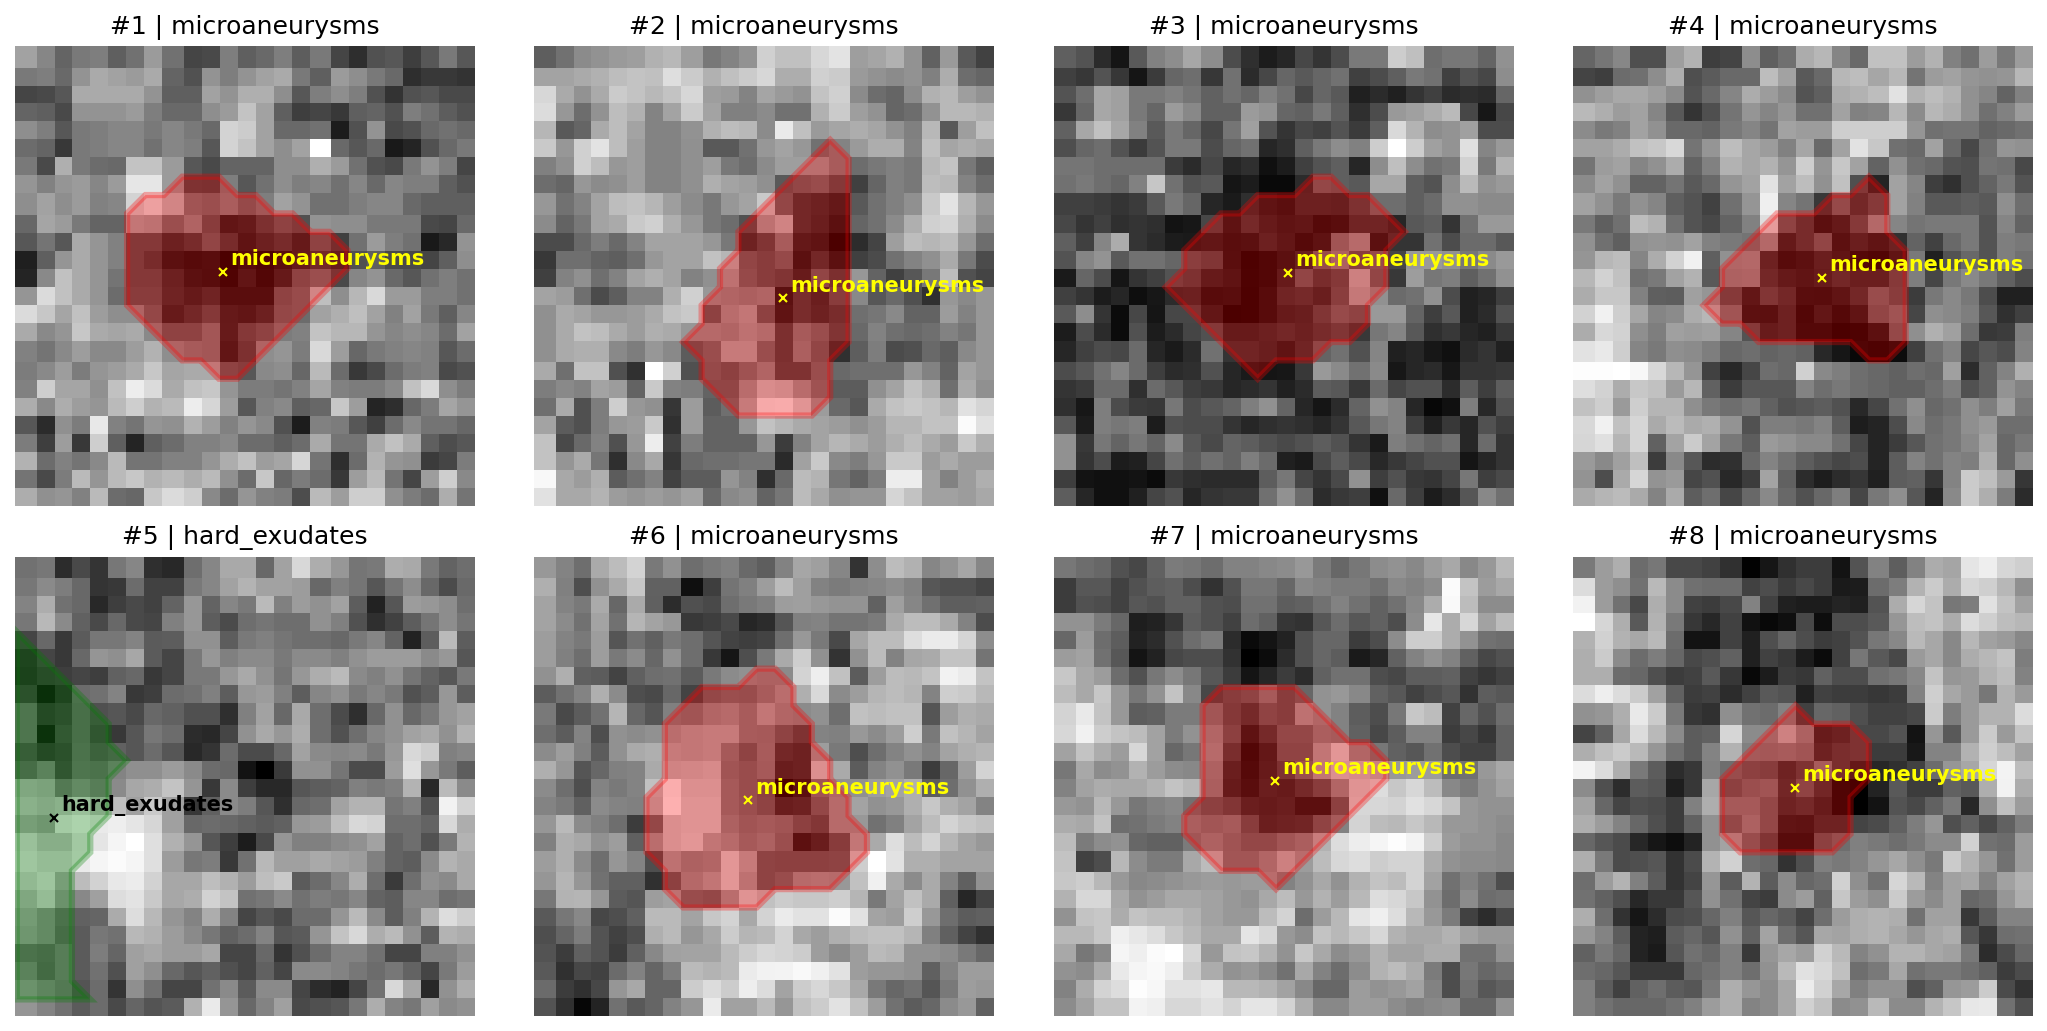

In [58]:
idx_1 = [1, 2, 3, 4, 5, 6, 7, 8]

subset_df = patches_df[patches_df["patch_no"].isin(idx_1)]
plot_patch_with_lesions(subset_df, n_cols=4, patch_size=25, resize_to=128)


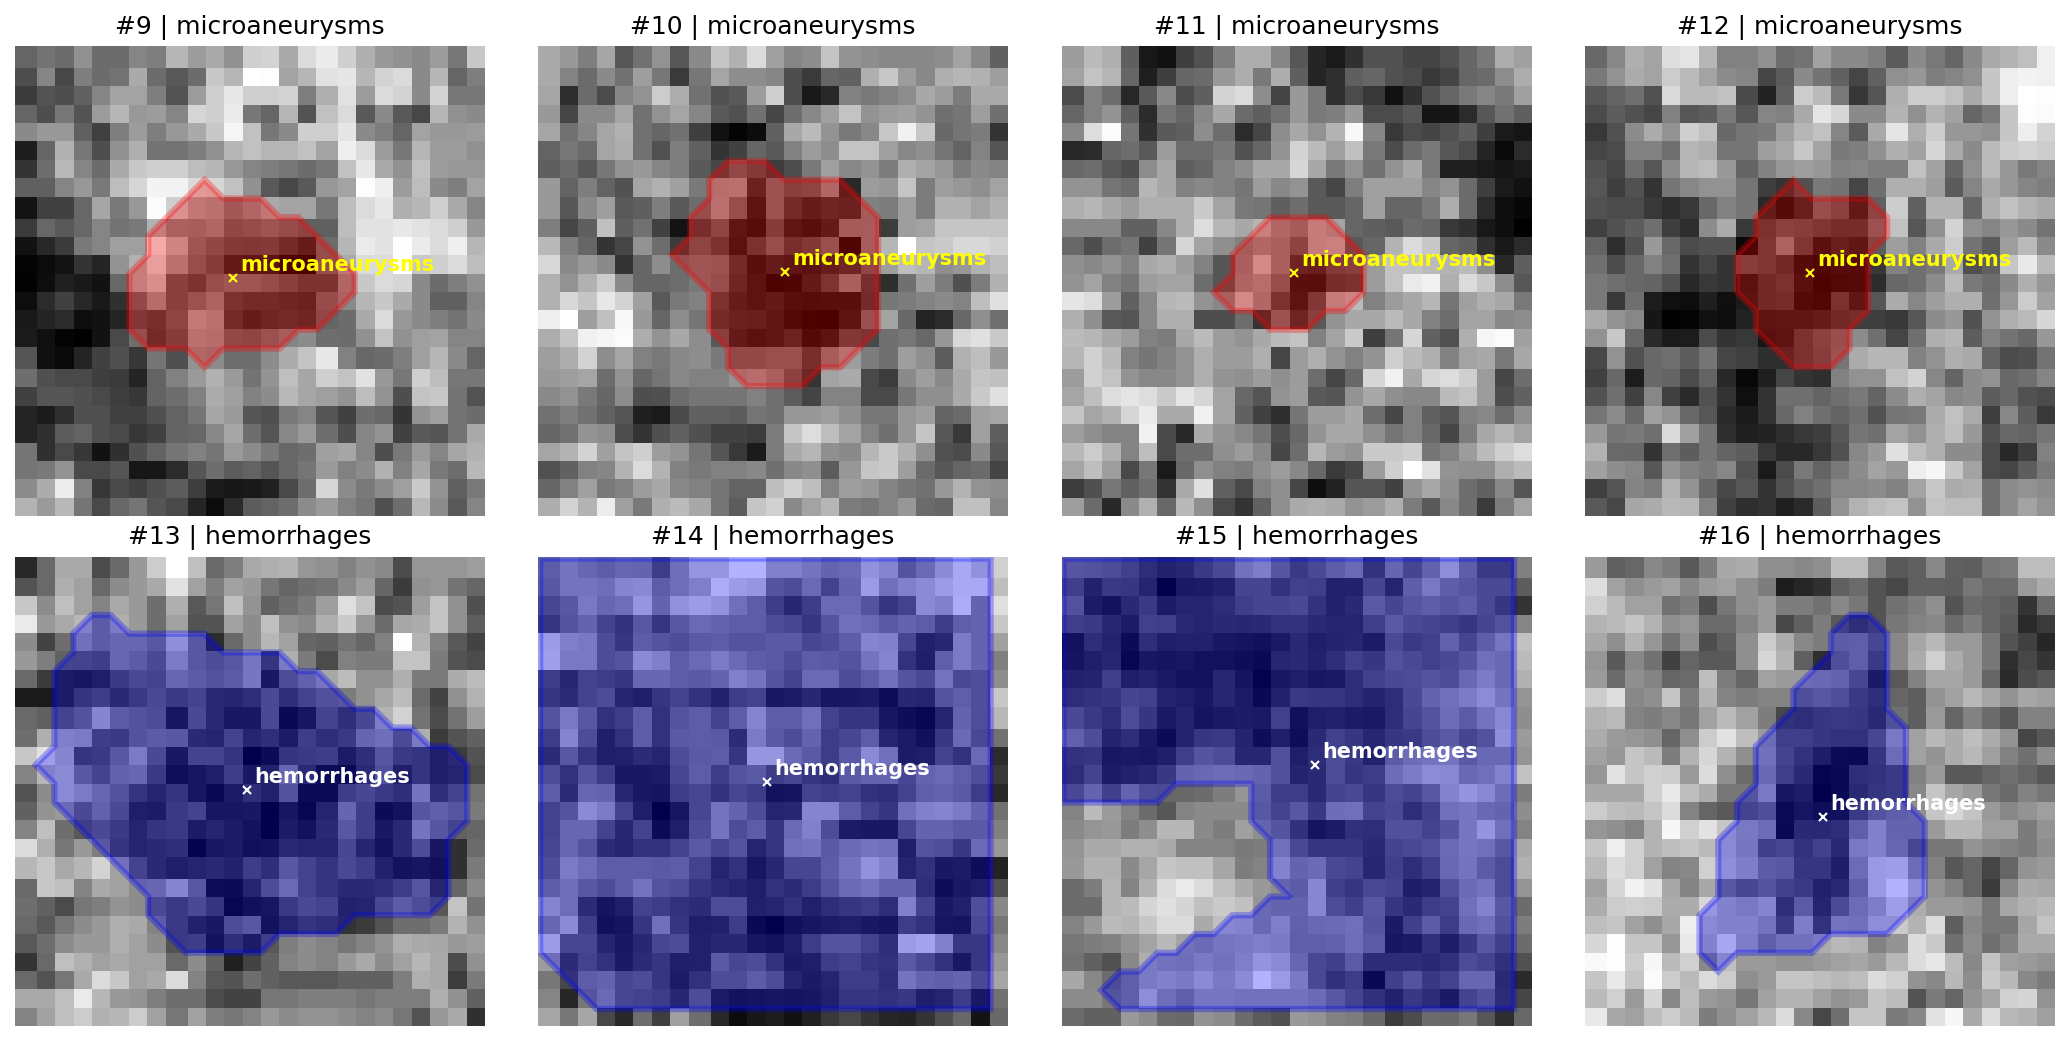

In [59]:
idx_2 = [9, 10, 11, 12, 13, 14, 15, 16]

subset_df = patches_df[patches_df["patch_no"].isin(idx_2)]
plot_patch_with_lesions(subset_df, n_cols=4, patch_size=25, resize_to=128)


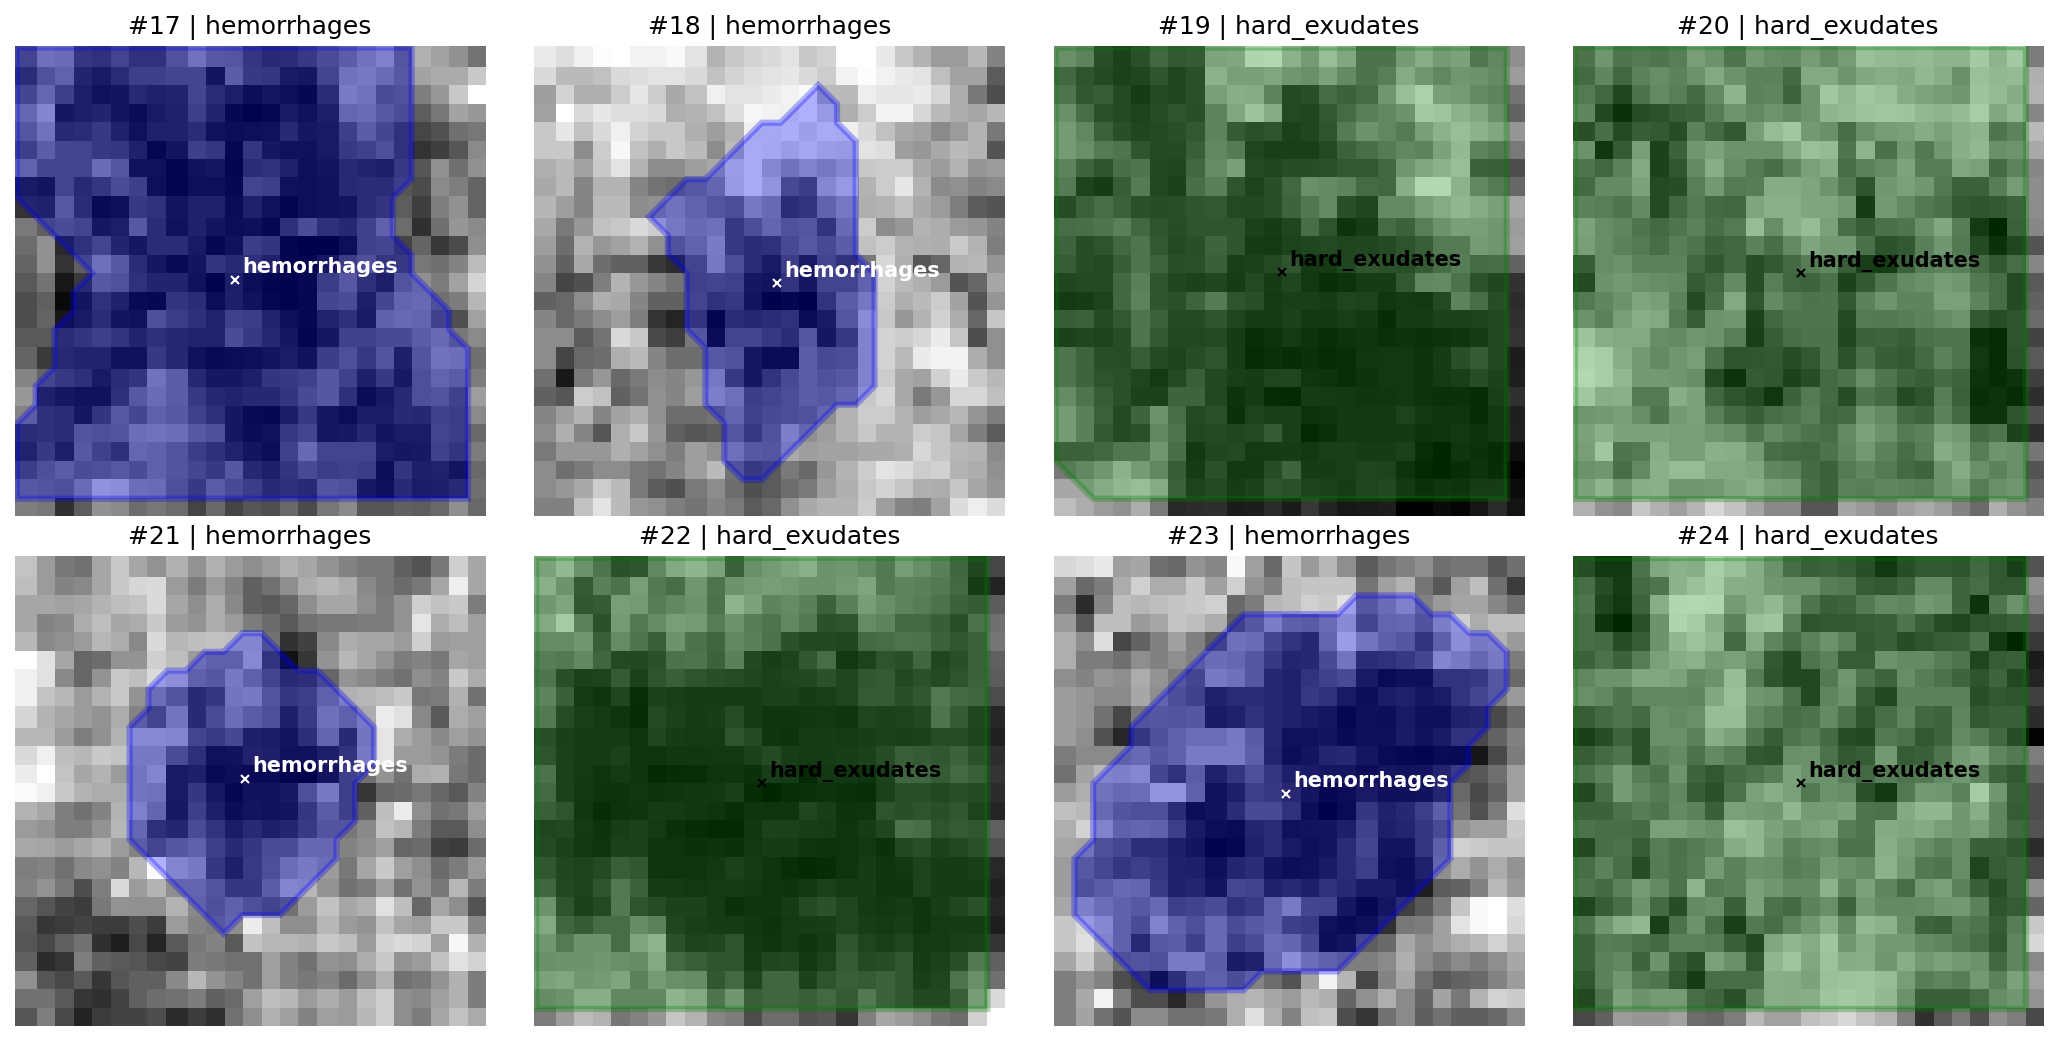

In [60]:
idx_3 = [17, 18, 19, 20, 21, 22, 23, 24]

subset_df = patches_df[patches_df["patch_no"].isin(idx_3)]
plot_patch_with_lesions(subset_df, n_cols=4, patch_size=25, resize_to=128)


Skipped shape for hard_exudates: 'MultiPolygon' object has no attribute 'exterior'


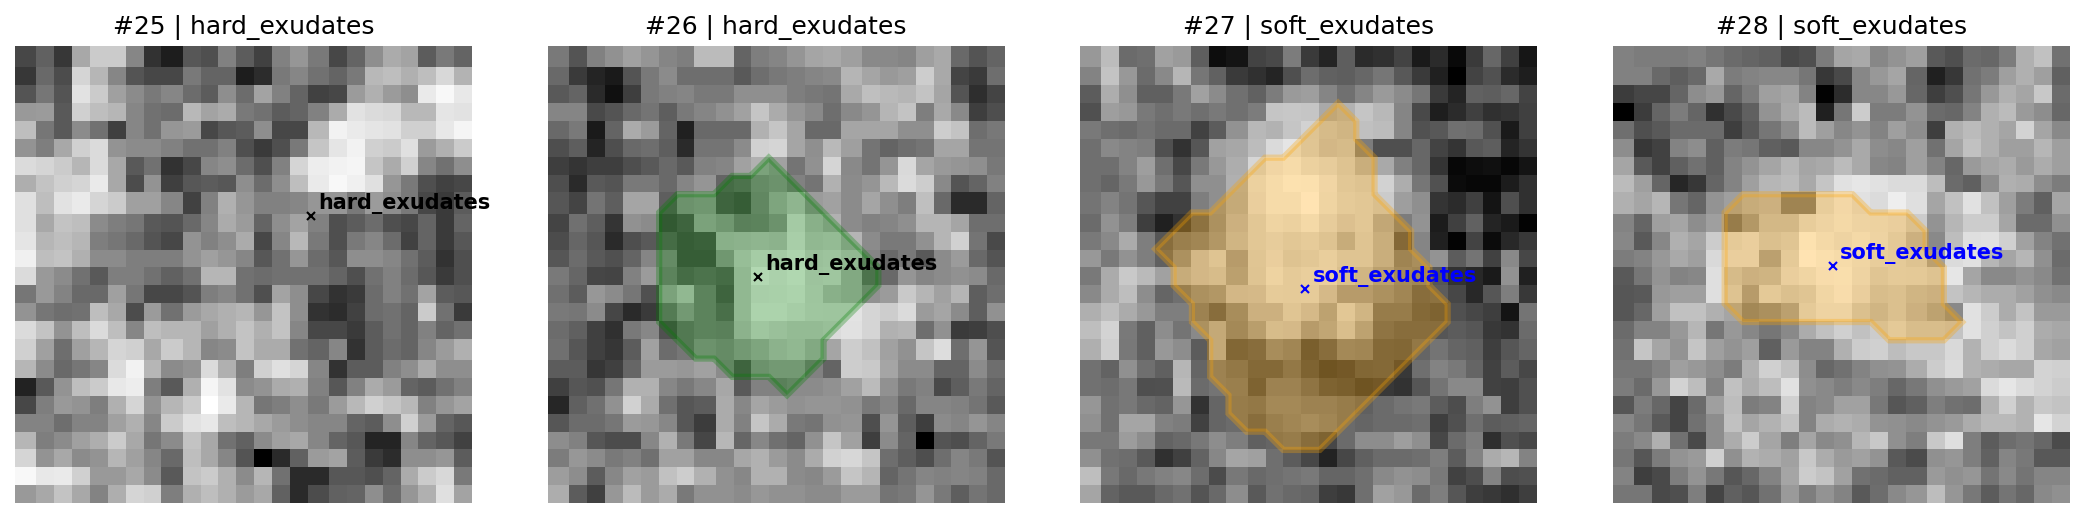

In [61]:
idx_4 = [25, 26, 27, 28]

subset_df = patches_df[patches_df["patch_no"].isin(idx_4)]
plot_patch_with_lesions(subset_df, n_cols=4, patch_size=25, resize_to=128)
